## Problem Statement

Conservation Internaitonal's TEAM has labeled camera trap images of terrestial mammals

- Images require manual classification from experts in the field
- Many of the images are misclassified
- There is a class of unlabeled images
- There is a class of unknown images

## Wildlife Image Classification Literature Review
1. SVM Models
2. Learning Models (Convolutional Neural Network)

## Bag of Visual Words

## Feature Extraction
- Manual Cropping
- Image Segmentation with Graph Cut 
http://cmp.felk.cvut.cz/~smidm/python-packages-for-graph-cuts-on-images.html
- Scale Invariant Feature Transform (SIFT)
- Cell-structured Local Binary Pattern (cLBP) descriptor
- Fisher Vector Coding
- Spatial Pyramid Strategy
- Average Pooling

## TEAM Terrestial Species Images Limitations
- Highly unbalanced classes of species
- Manually classified by experts in the field
- Context matters: busrts of images are understood by experts as a sequence of images containing the identified species (part of animal species v whole animal species in frame problem)
- Classification contain errors
- Existence of endangered species images preclude the use of citizen scientists to help classify images

## Experiments

In [2]:
import pandas as pd
import numpy as np
import os
import cv2

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Dense, Activation
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import backend as K

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot as plt
%matplotlib inline
ROWS = 180  #720
COLS = 320 #1280
CHANNELS = 3
SPECIES_CLASSES = ['Loxodonta']
DIRECTORY = "/Users/Luxive/OneDrive/Machine_Learning/Harvard/Final_Project/"

Using TensorFlow backend.


In [3]:
import sys
print(sys.version)
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)
print("OpenCV version",cv2.__version__)

3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
Pandas version: 0.19.1
Numpy version: 1.11.2
OpenCV version 3.1.0


## Sample Images

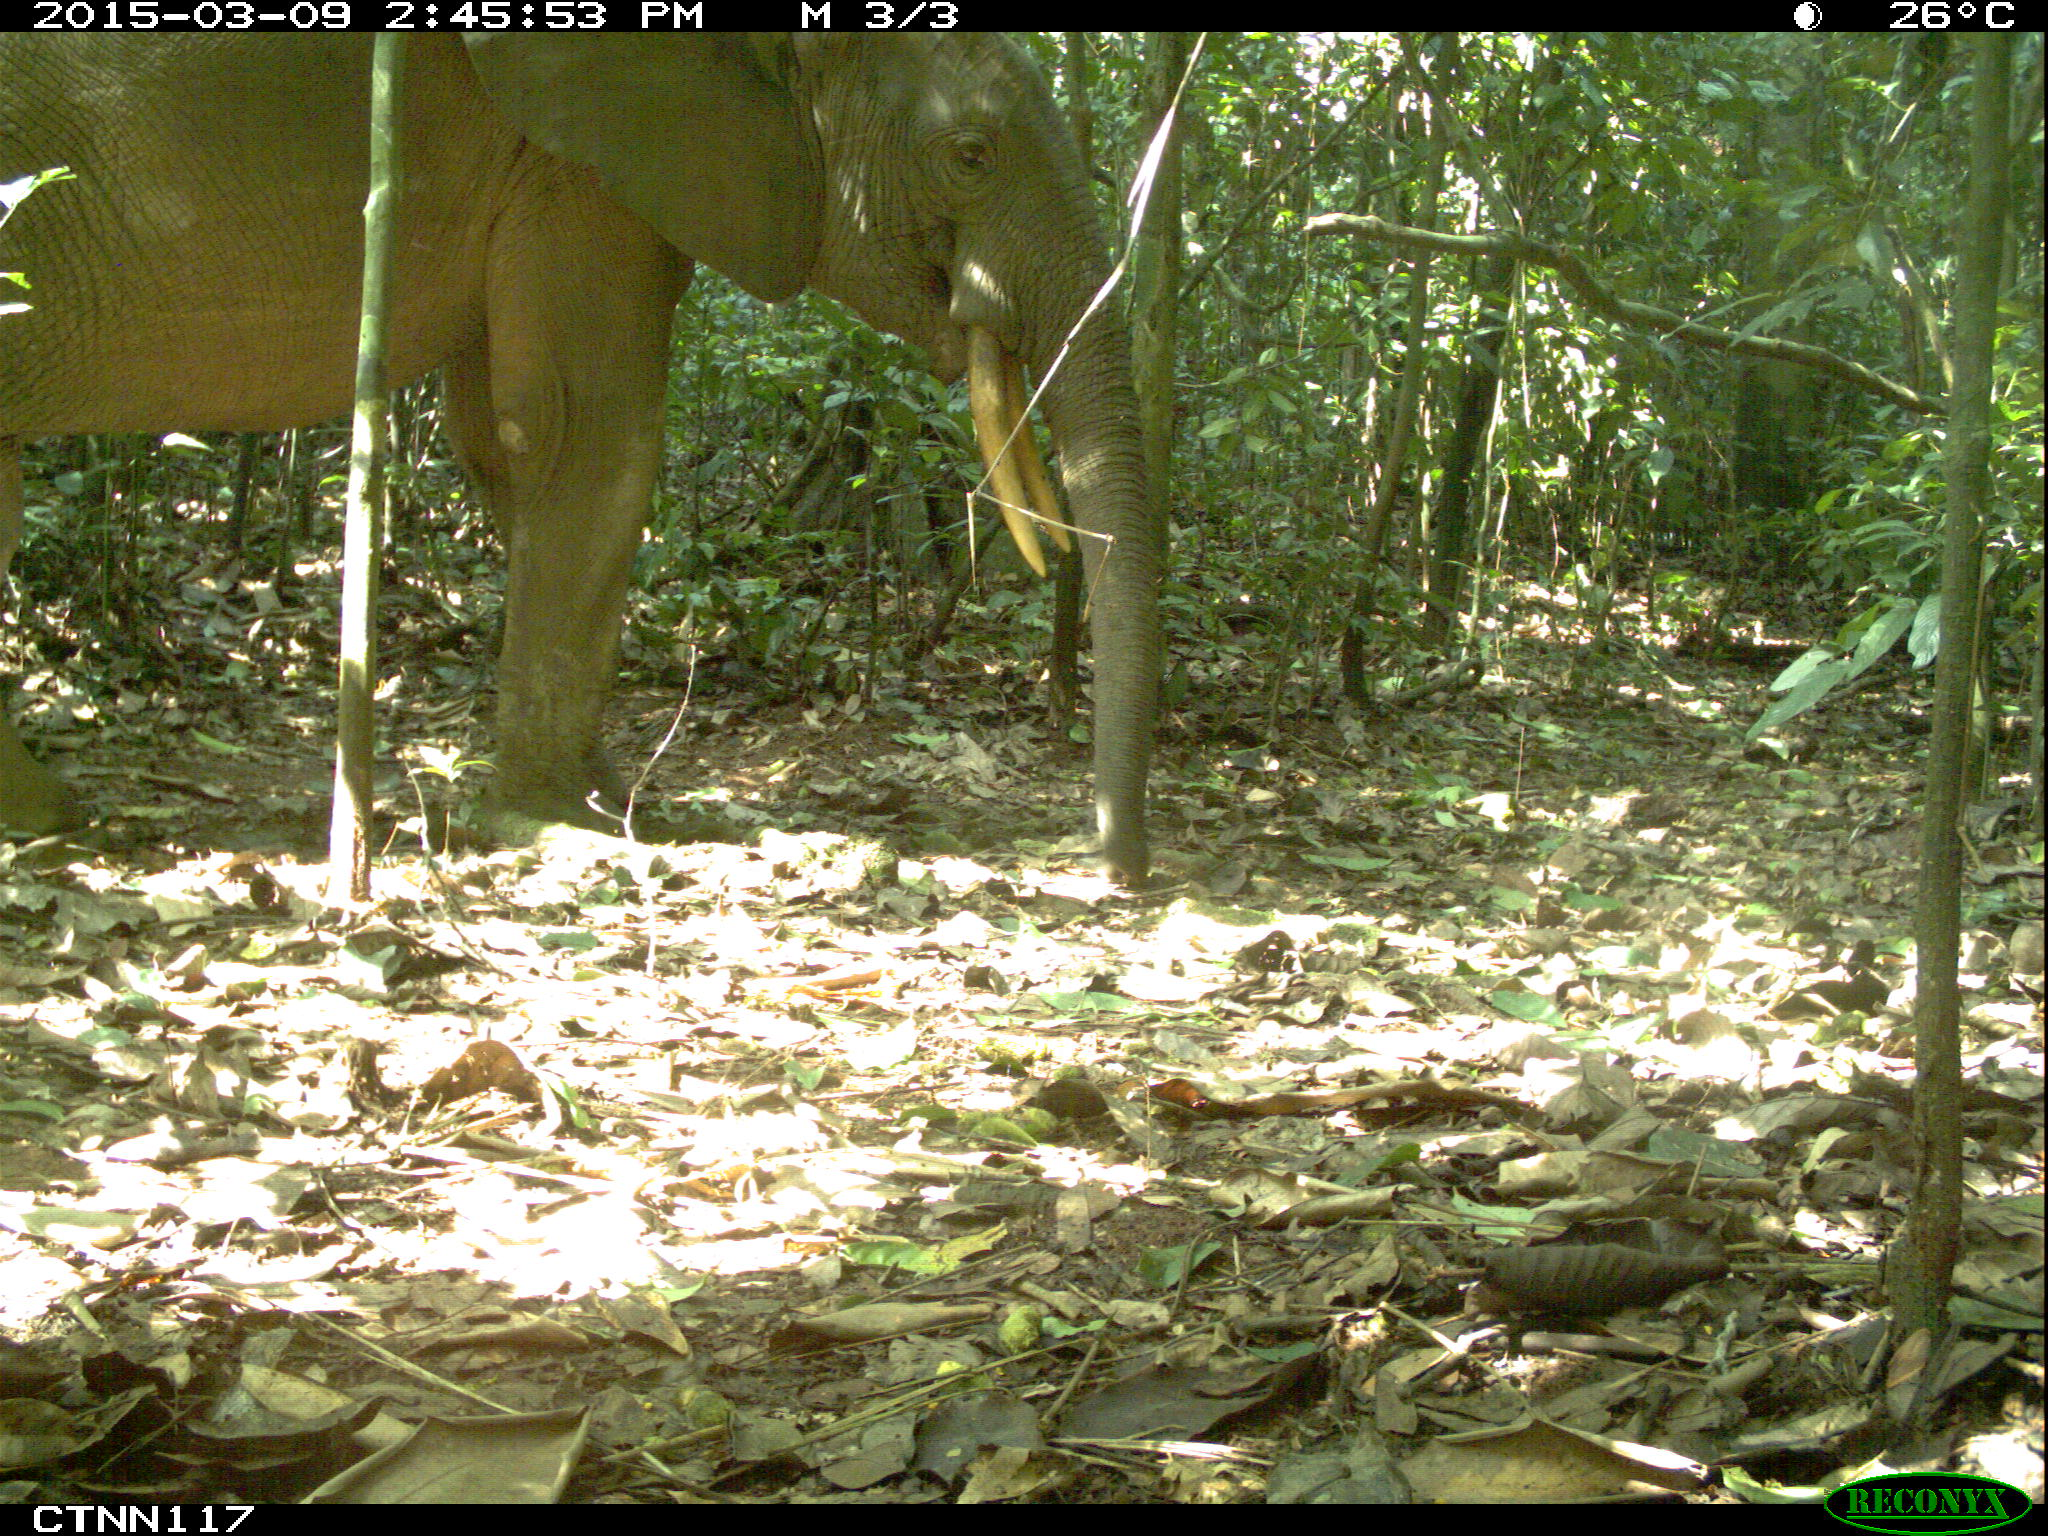

In [4]:
from IPython.display import Image
filename = "/Users/Luxive/Dropbox/TEAM_Machine Learning/Loxodonta/TEAM-DataPackage-20161115123529_3242/Terrestrial Vertebrate/NNN/2014.01/CT-NNN-1/CT-NNN-1-17/100-IMG_4191.JPG"
Image(filename) 

(<matplotlib.axes._subplots.AxesSubplot at 0x119abab00>,
 <matplotlib.image.AxesImage at 0x119b4c7b8>)

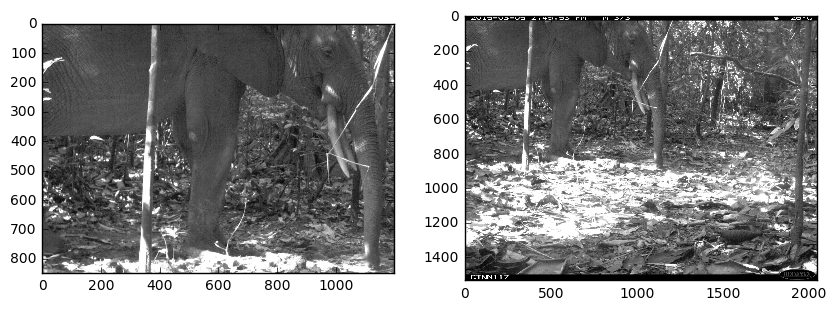

In [5]:
img_rows, img_cols= 850, 1200
im_array = cv2.imread(filename,0)
template = np.zeros([ img_rows, img_cols], dtype='uint8') # initialisation of the template
template[:, :] = im_array[50:900,0:1200] # I try multiple times to find the correct rectangle. 
#template /= 255.
plt.subplots(figsize=(10, 7))
plt.subplot(121),plt.imshow(template, cmap='gray') 
plt.subplot(122), plt.imshow(im_array, cmap='gray')

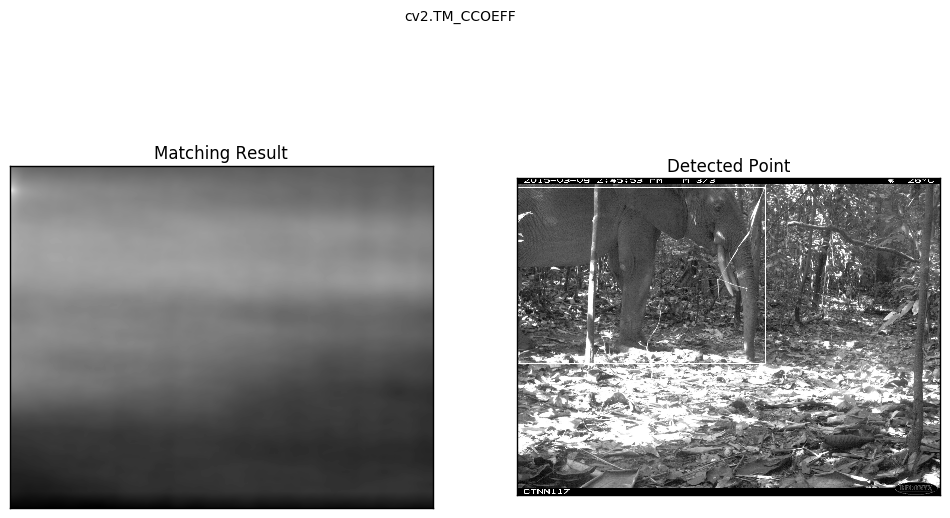

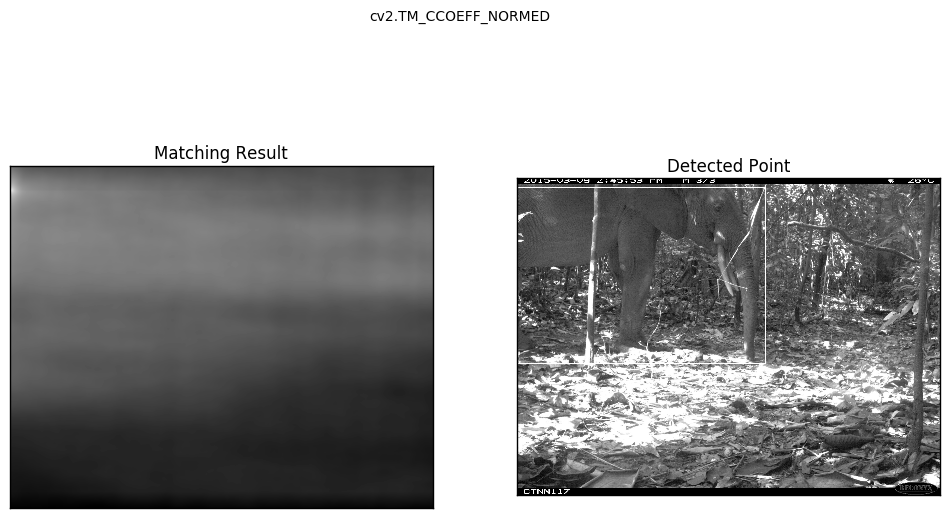

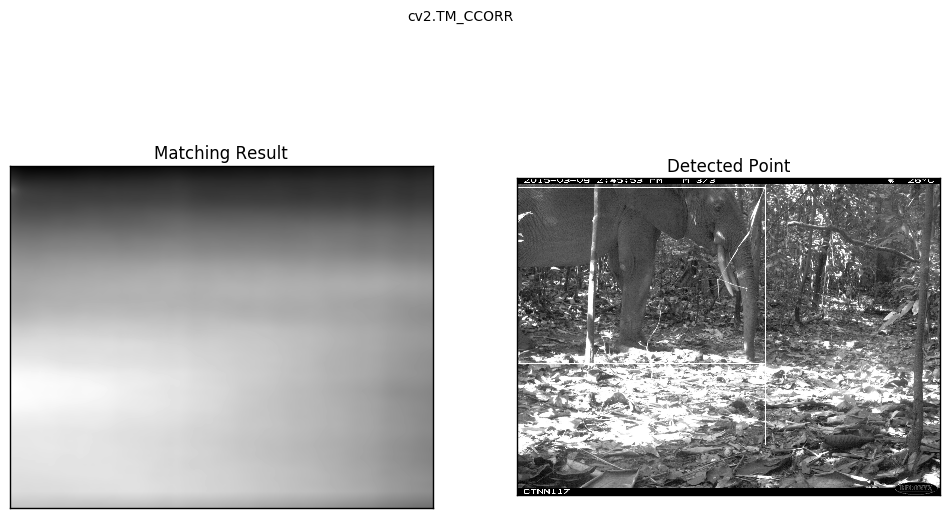

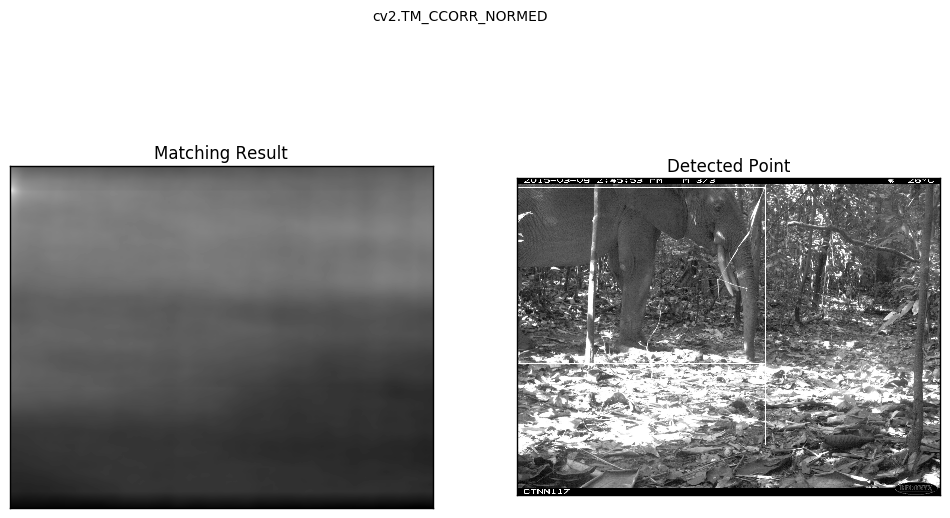

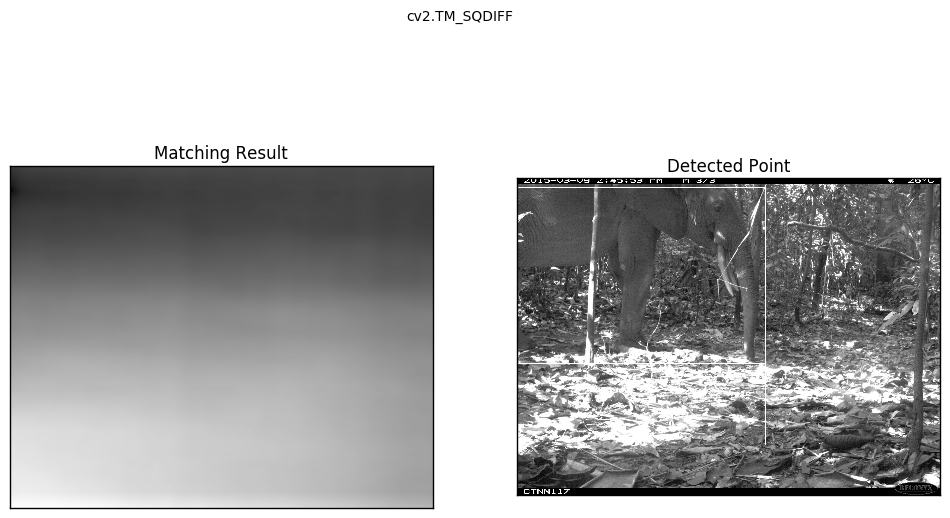

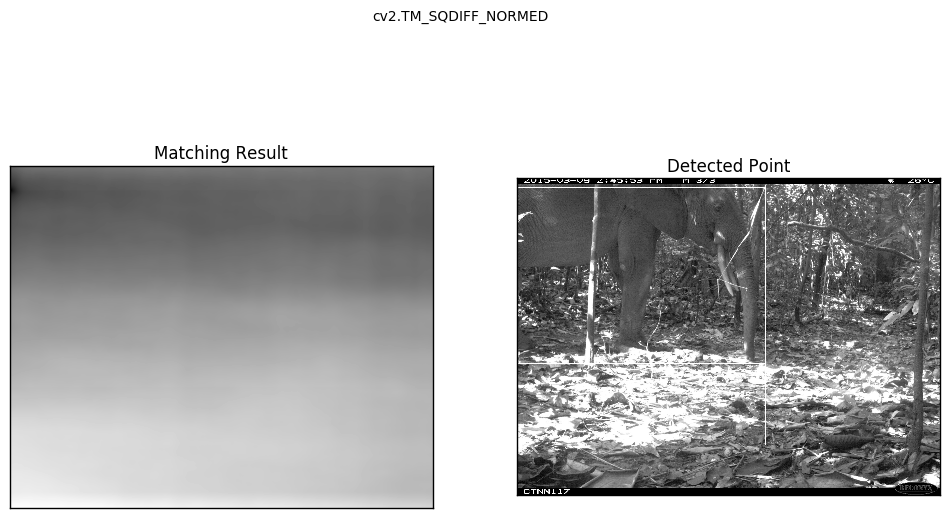

In [6]:
img = cv2.imread(filename,0) 
img2 = img
w, h = template.shape[::-1]

# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img = img2
    method = eval(meth)
 
    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, 255, 2)
    fig, ax = plt.subplots(figsize=(12, 7))
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray') #,aspect='auto'
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)

    plt.show()

In [7]:
def get_images(species):
    """Load files from directory folder"""
    """Use os.walk() traversal method"""
    images = []
    for root, dirs, files in os.walk(DIRECTORY+species):
        for file in files:
            if file.endswith(".JPG"):
                images.append(file)
    return images

def read_image(src):
    """Read and resize individual images"""
    im = cv2.imread(src, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (COLS, ROWS), interpolation=cv2.INTER_CUBIC)
    return im

files = []
y_all = []

for species in SPECIES_CLASSES:
    species_files = get_images(species)
    files.extend(species_files)

    y_species = np.tile(species, len(species_files))
    y_all.extend(y_species)
    print("{0} photos of {1}".format(len(species_files), species))
    
y_all = np.array(y_all)

258 photos of Loxodonta


In [8]:
X_all = np.ndarray((len(files), ROWS, COLS, CHANNELS), dtype=np.uint8)
for i, im in enumerate(files): 
    X_all[i] = read_image(DIRECTORY+species+'/'+im)
    if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))

print(X_all.shape)

Processed 0 of 258
(258, 180, 320, 3)


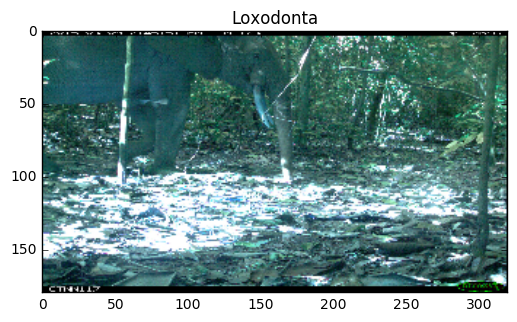

In [9]:
# check out a species from each class
uniq = np.unique(y_all, return_index=True)
for f, i in zip(uniq[0], uniq[1]):
    plt.imshow(X_all[i])
    plt.title(f)
    plt.show()

In [10]:
# One Hot Encoding Labels
y_all = LabelEncoder().fit_transform(y_all)
y_all = np_utils.to_categorical(y_all)

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, 
                                                    test_size=0.2, random_state=23, 
                                                    stratify=y_all)

In [11]:
optimizer = RMSprop(lr=1e-4)
objective = 'sparse_categorical_crossentropy'

def center_normalize(x):
    return (x - K.mean(x)) / K.std(x)

model = Sequential()

model.add(Activation(activation=center_normalize, input_shape=(ROWS, COLS, CHANNELS)))

model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))

model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', dim_ordering='tf'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='tf'))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(len(SPECIES_CLASSES)))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')        
        
model.fit(X_train, y_train, batch_size=64, nb_epoch=1,
              validation_split=0.2, verbose=1, shuffle=True, callbacks=[early_stopping])

In [12]:
# bb_metadata = pd.read_csv("data/TV-20161130134129_5302.csv", header=46,low_memory=False)
nnn_metadata = pd.read_csv("/Users/Luxive/Dropbox/TEAM_Machine Learning/Loxodonta/TEAM-DataPackage-20161205130624_1284/Terrestrial Vertebrate/TV-20161205130624_1284.csv", header=46,low_memory=False)
# vr_metadata = pd.read_csv("data/TV-20161204185054_1706.csv", header=46,low_memory=False)
# udz_metadata = pd.read_csv("data/TV-20161204185203_1536.csv", header=46,low_memory=False)

In [ ]:
df_metadata = pd.concat([bb_metadata, nnn_metadata, vr_metadata, udz_metadata])

In [13]:
nnn_metadata['Species'].count()

31485

In [14]:
directory = "/Users/Luxive/Dropbox/TEAM_Machine Learning/"

def count_images(species):
    """Load files from directory folder"""
    """Use os.walk() traversal method"""
    i = 0
    for root, dirs, files in os.walk(directory+species):
        for file in files:
            if file.endswith(".JPG"):
                i += 1
    return i

actual_images = count_images(species)
print(actual_images)

31423


In [15]:
# expected versus actual images
series = pd.Series({"ExpectedImages": nnn_metadata['Species'].count(), "ActualImages": actual_images})
image_check = pd.DataFrame([series])
image_check['Difference'] = image_check['ExpectedImages'] - image_check['ActualImages']
image_check

ActualImages  ExpectedImages  Difference
0         31423           31485          62

In [16]:
# Number of null values and data types per column
# You can use DataFrame.info() as well
null_df = pd.DataFrame({'number of null values': nnn_metadata.isnull().sum(),
                        'data type' : nnn_metadata.dtypes,
                        'count': nnn_metadata.count()})
null_df

count data type  number of null values
ID                             31485     int64                      0
Site Name                      31485    object                      0
Sampling Unit Name             31485    object                      0
Latitude                       31485   float64                      0
Longitude                      31485   float64                      0
Sampling Period                31485   float64                      0
Photo Type                     31485    object                      0
Photo Date                     31485    object                      0
Photo Time                     31485    object                      0
Raw Name                       31485    object                      0
Photo Notes                        0   float64                  31485
Photo ID URL                   31485    object                      0
Class                          31485    object                      0
Order                          31485    object                      0
Family                         31485    object                      0
Genus                          31485    object                      0
Species                        31485    object                      0
Number of Animals              31485     int64                      0
Person Identifying the Photo   31485    object                      0
Camera Serial Number           31485    object                      0
Memory Card Serial Number      31485    object                      0
Camera Notes                    4503    object                  26982
Camera Start Date and Time     31485    object                      0
Camera End Date and Time       31485    object                      0
Person setting up the Camera   31485    object                      0
Person picking up the Camera   31485    object                      0
Camera Make                    25824    object                   5661
Camera Model                   25824    object                   5661
Flash                          25824   float64                   5661
Exposure Time                  31485    object                      0
Sequence Info                  27212    object                   4273
Triplet Number                 27212    object                   4273
Moon Phase                     27212    object                   4273
Temperature                    27212   float64                   4273
Camera Firmware Version        21551    object                   9934
Protocol Version               31485    object                      0
Data Set Creator Institutions  31485    object                      0
Data Set Creator Scientist     29037    object                   2448
Data Set Contact               31485    object                      0
Data Level                     31485    object                      0

In [17]:
from IPython.core.display import HTML
def css_styling():
    styles = open('css/custom.css', 'r').read()
    return HTML("<style>"+styles+"</style>")
css_styling()